# CSE 402 Final Project

## MobileNetV2

### Imports

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import torchvision.models as models
import torch.nn.functional as F
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.datasets import load_sample_image
import numpy as np
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import torchvision
from torchvision import transforms
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

### Data Loading and Preprocessing

In [4]:
#!jar xf 'Celebrity Faces Dataset (1).zip'

In [5]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:

#directory = '/Users/ethandemott/Documents/cse402/project/Celebrity Faces Dataset'
directory = '/content/Celebrity Faces Dataset'
# Define image transformation for MobileNetV2
target_size = (224, 224)  # Required size for MobileNetV2
transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmentation_transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load images and labels
images, labels = [], []
for root, _, files in os.walk(directory):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(root, file)
            image = Image.open(image_path).convert('RGB')
            images.append(image)
            labels.append(os.path.basename(root))  # Label is folder name

# Convert lists to tensors
label_encoder = LabelEncoder()
labels_encoded = torch.tensor(label_encoder.fit_transform(labels))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Model Training

In [7]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

all_predictions = []
all_true_labels = []

for fold, (train_idx, test_idx) in enumerate(kf.split(images)):
    print(f'Fold {fold + 1}')

    # Setup the MobileNetV2 model
    num_classes = len(label_encoder.classes_)
    model = models.efficientnet_b0(weights='DEFAULT')  # Load pretrained weights
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)  # Update final layer
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)

    # Apply augmentation for training images
    train_images = [augmentation_transform(images[i]) for i in train_idx]
    train_labels = [labels_encoded[i] for i in train_idx]
    train_dataset = TensorDataset(torch.stack(train_images), torch.tensor(train_labels))

    # Apply basic transform for testing images
    test_images = [transform(images[i]) for i in test_idx]
    test_labels = [labels_encoded[i] for i in test_idx]
    test_dataset = TensorDataset(torch.stack(test_images), torch.tensor(test_labels))

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Train the model
    model.train()
    for epoch in range(10):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

    # Evaluate the model
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(targets.cpu().numpy())

    print(f'Fold {fold + 1} Accuracy: {correct / total:.4f}')

overall_accuracy = sum(np.array(all_predictions) == np.array(all_true_labels)) / len(all_true_labels)
print(f'Overall Cross-Validation Accuracy: {overall_accuracy:.4f}')


Fold 1


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 173MB/s]


Epoch 1, Loss: 1.9887251176086127
Epoch 2, Loss: 0.7397450813475777
Epoch 3, Loss: 0.28223832397192133
Epoch 4, Loss: 0.1737352721758333
Epoch 5, Loss: 0.14237647711792412
Epoch 6, Loss: 0.08761915445839073
Epoch 7, Loss: 0.10940901464873962
Epoch 8, Loss: 0.09998244962965448
Epoch 9, Loss: 0.06545898819561391
Epoch 10, Loss: 0.051001805010909104
Fold 1 Accuracy: 0.8556
Fold 2
Epoch 1, Loss: 2.0354740689782536
Epoch 2, Loss: 0.8294390916239982
Epoch 3, Loss: 0.34367550164461136
Epoch 4, Loss: 0.17625784077772907
Epoch 5, Loss: 0.10789948182326614
Epoch 6, Loss: 0.12270133582619476
Epoch 7, Loss: 0.11024273443492312
Epoch 8, Loss: 0.0909079877550111
Epoch 9, Loss: 0.07410494185294773
Epoch 10, Loss: 0.07395773229426612
Fold 2 Accuracy: 0.9000
Fold 3
Epoch 1, Loss: 2.0213696121000777
Epoch 2, Loss: 0.7842398274178598
Epoch 3, Loss: 0.32543326351864665
Epoch 4, Loss: 0.1886883582919836
Epoch 5, Loss: 0.12688769586384296
Epoch 6, Loss: 0.11247074631426264
Epoch 7, Loss: 0.07782804991538618

### Confusion Matrix

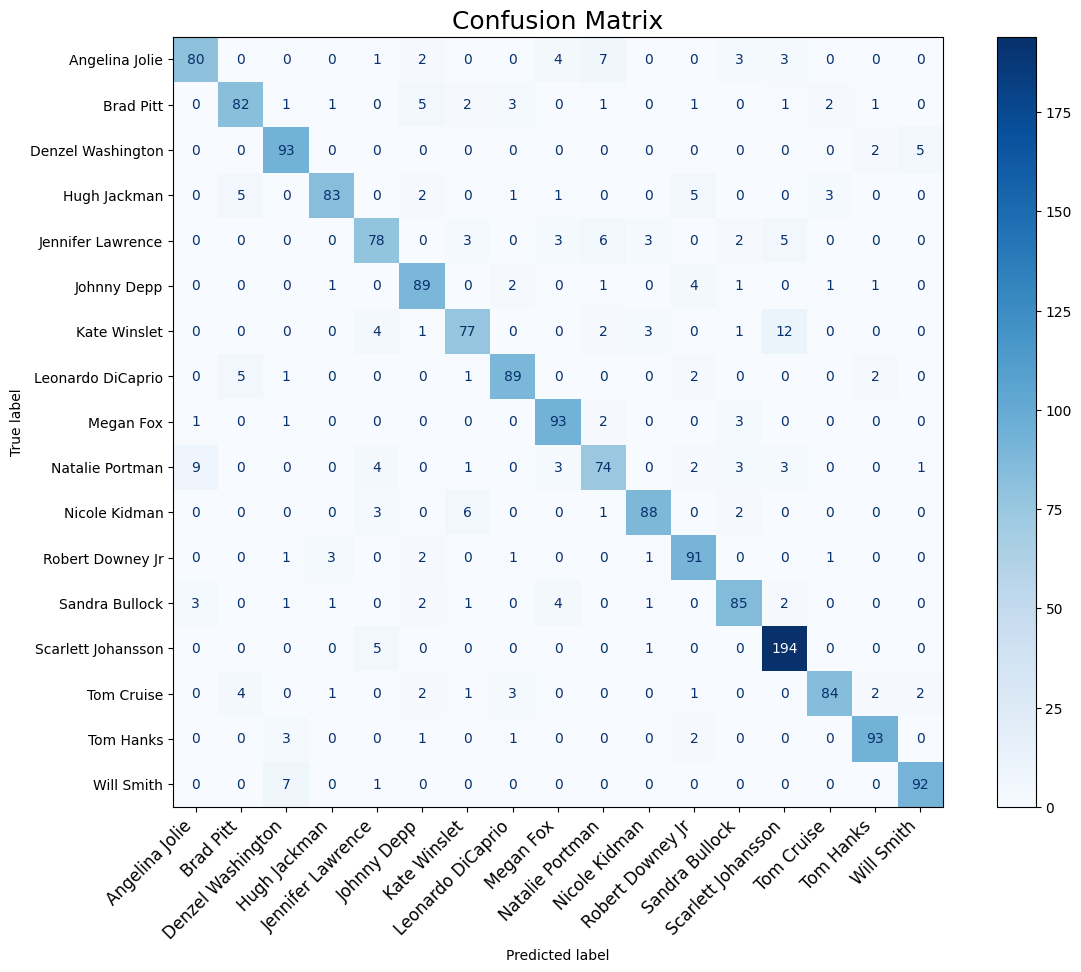

In [8]:
cm = confusion_matrix(all_true_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(14, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)

plt.title("Confusion Matrix", fontsize=18)
plt.show()

In [ ]:
torch.save(model.state_dict(), 'trained_model.pth')
